# Predicting Diamond Prices

### Data Set Information:

**A dataset containing the prices and other features of almost 54,000 diamonds.**

In [34]:
!pip install XGBOOST

### Features description

**Number of Attributes: 10 (9 predictive features, 1 target)**

Feature Information: A data frame with 53,940 rows and 10 variables:

price: price in US dollars (\$326--\$18,823) **(target)**

carat: weight of the diamond (0.2--5.01)

cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: diamond colour, from J (worst) to D (best)

clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x: length in mm (0--10.74)

y: width in mm (0--58.9)

z: depth in mm (0--31.8)

depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table: width of top of diamond relative to widest point (43--95)

In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
%matplotlib inline
pd.set_option('display.max_columns',50)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

## 0. Data Preparation

In [2]:
# importing data
#data_path= '../data/diamonds.csv'
diamonds = pd.read_csv("diamonds.csv")

In [3]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
diamonds.shape

(53940, 10)

In [5]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
diamonds_corr = diamonds.corr()
diamonds_corr

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


<AxesSubplot:>

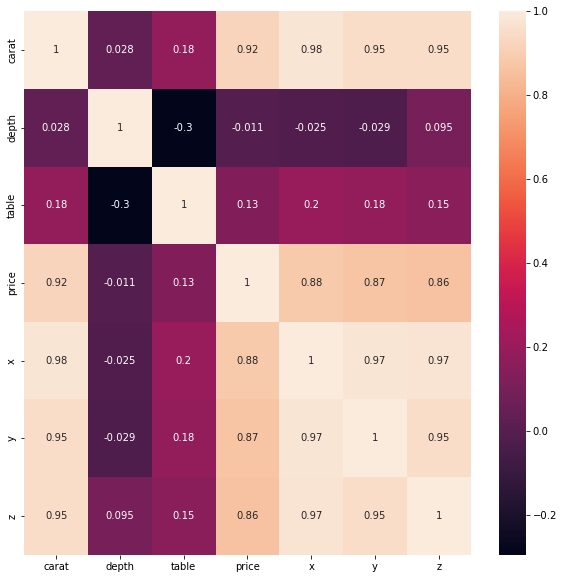

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(diamonds_corr, annot=True)

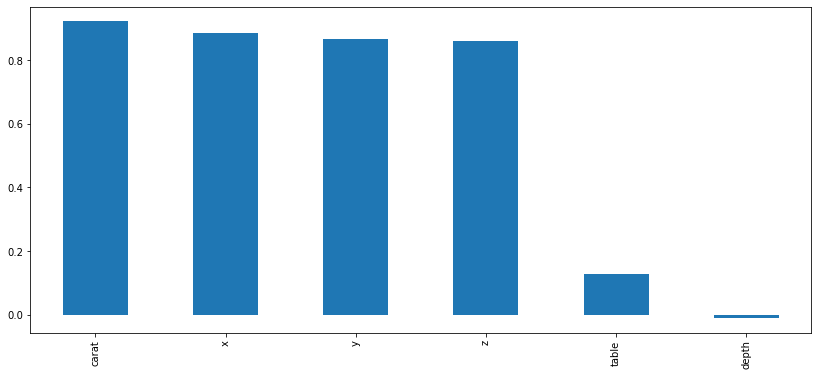

In [9]:
#Correlation of each feature with the Target
corr_with_price = diamonds.corr()["price"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_price.drop("price").plot.bar()
plt.show();

One of the transformations we must perform is to tranform the categorical features to the one-hot-encoding format.

In [10]:
print(diamonds['cut'].unique())
print(diamonds['color'].unique())
print(diamonds['clarity'].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [11]:
diamonds['cut'].head()

0      Ideal
1    Premium
2       Good
3    Premium
4       Good
Name: cut, dtype: object

In [12]:
#Apply one hot encoding
#diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)],axis=1)
#diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)],axis=1)
#diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)],axis=1)
#diamonds.drop(['cut','color','clarity'], axis=1, inplace=True)


In [13]:
#Using label encoder to encode labels
from sklearn.preprocessing import LabelEncoder

en= LabelEncoder()
en1=LabelEncoder()
en2=LabelEncoder()
diamonds['cut']= en.fit_transform(diamonds['cut'])
diamonds['color']= en1.fit_transform(diamonds['color'])
diamonds['clarity']= en2.fit_transform(diamonds['clarity'])
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [14]:
print(diamonds['cut'].unique())
print(diamonds['color'].unique())
print(diamonds['clarity'].unique())

[2 3 1 4 0]
[1 5 6 4 2 3 0]
[3 2 4 5 7 6 0 1]


In [15]:
print(en.classes_)
print(en1.classes_)
print(en2.classes_)

['Fair' 'Good' 'Ideal' 'Premium' 'Very Good']
['D' 'E' 'F' 'G' 'H' 'I' 'J']
['I1' 'IF' 'SI1' 'SI2' 'VS1' 'VS2' 'VVS1' 'VVS2']


In [77]:
p='Good'

In [79]:
en.transform([p])[0]

1

In [80]:
filename = 'en.sav'
pickle.dump(en, open(filename, 'wb'))
filename = 'en1.sav'
pickle.dump(en1, open(filename, 'wb'))
filename = 'en2.sav'
pickle.dump(en2, open(filename, 'wb'))

In [75]:
en.transform(['Good'])[0]

1

In [16]:
#Check for multicollinearity using Heat Map after one hot encoding.

<AxesSubplot:xlabel='carat', ylabel='price'>

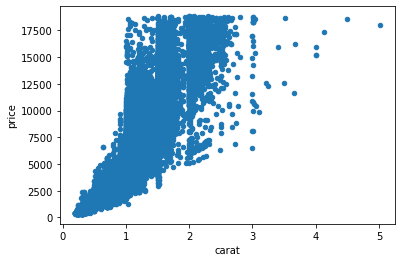

In [17]:
diamonds.plot.scatter(x='carat', y='price')

### Scaling: an important operation

Since the features have different scales (<code>carat</code> goes from 0 to 5, <code>y</code> goes from 0 to 58) we need to be careful. Making sure that each feature has approximately the same scale can be a crucial preprocessing step. In this case we will use the <code>RobustScaler</code> object which scales the features to a common scale and it is robust to outliers.

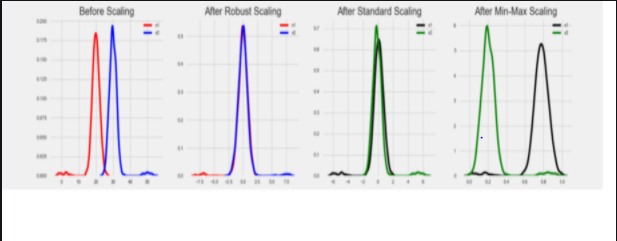

### Getting the train and test sets

In [18]:
#Import important libraries for training,preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import RobustScaler #another preferable choice is "StandardScaler (works better most times)"

In [19]:
target_name = 'price' #set target giving it a name
robust_scaler = RobustScaler() #prepare the scaler
X = diamonds.drop('price', axis=1) #assign the all features to X variable.
X = robust_scaler.fit_transform(X) #notice we drop away the target before applying scaling. Do not scale the target.
y = diamonds[target_name] #assign the target to y variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) #do your data splitting

# A. Linear Regression

In [20]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LinearRegression
# 2. Create an instance of the estimator
linear_regression = LinearRegression()
# 3. Use the trainning data to train the estimator
linear_regression.fit(X_train, y_train)

LinearRegression()

In [21]:
#Prediction and Model Evaluation (R-squared,MSE,RMSE,MAE)
y_train_pred1 = linear_regression.predict(X_train) #Train (Already seen this)
y_pred1 = linear_regression.predict(X_test) # Test(New)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))

train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)

train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.2f' % train_rmse1)
print('Test RMSE: %.2f' % test_rmse1)

Train r2 score:  0.8708204000804692
Test r2 score:  0.8829256132247099
Train RMSE: 1349.71
Test RMSE: 1363.54


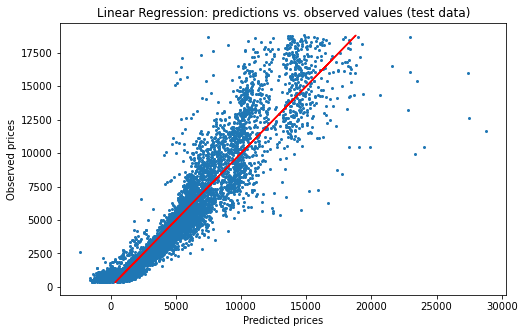

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(linear_regression.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Linear Regression: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

# B. K-Nearest Neighbors Model

In [23]:
# 1. Import the estimator object (model)
from sklearn.neighbors import KNeighborsRegressor
# 2. Create an instance of the estimator
knn = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='euclidean', n_jobs=-1)
# 3. Use the trainning data to train the estimator
knn.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_jobs=-1, n_neighbors=10,
                    weights='distance')

In [24]:
#Prediction and Model Evaluation
y_train_pred2 = knn.predict(X_train)
y_pred2 = knn.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.2f' % train_rmse2)
print('Test RMSE: %.2f' % test_rmse2)

Train r2 score:  0.9999953748088543
Test r2 score:  0.9547075558849942
Train RMSE: 8.58
Test RMSE: 848.11


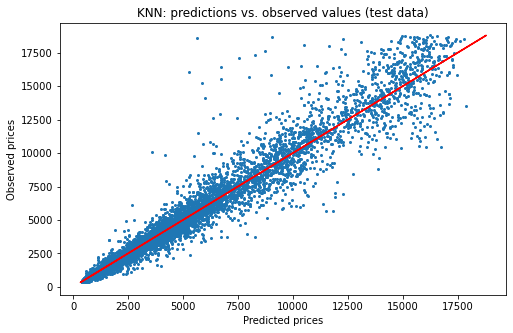

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(knn.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('KNN: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

# C. DECISION TREE MODEL

In [26]:
# 1. Import the estimator object (model)
from sklearn.tree import DecisionTreeRegressor
# 2. Create an instance of the estimator
dtree = DecisionTreeRegressor(max_depth=3)
# 3. Use the trainning data to train the estimator
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [27]:
y_train_pred3 = dtree.predict(X_train)
y_pred3 = dtree.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.2f' % train_rmse3)
print('Test RMSE: %.2f' % test_rmse3)

Train r2 score:  0.8663967745820225
Test r2 score:  0.8822042303261373
Train RMSE: 1369.94
Test RMSE: 1367.73


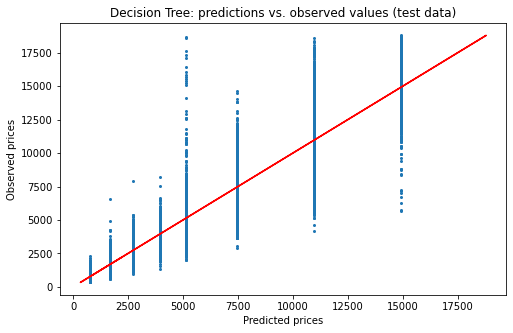

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(dtree.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Decision Tree: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

# D. RANDOM FOREST MODEL

In [29]:
from sklearn.ensemble import RandomForestRegressor
# 1. Import the estimator object (model)
from sklearn.tree import DecisionTreeRegressor
# 2. Create an instance of the estimator
rf = RandomForestRegressor(max_depth=3) #Notice here also we are using here "random forest regressor" not "random forest classifier"
# 3. Use the trainning data to train the estimator
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3)

In [30]:
y_train_pred4 = rf.predict(X_train)
y_pred4 = rf.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.2f' % train_rmse4)
print('Test RMSE: %.2f' % test_rmse4)

Train r2 score:  0.8695071973901082
Test r2 score:  0.8849882491568836
Train RMSE: 1350.92
Test RMSE: 1351.47


# E. XGBOOST 

In [35]:
import xgboost as xgb 
xgb_model1 = xgb.XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
y_train_pred5 = xgb_model1.predict(X_train)
y_pred5 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.2f' % train_rmse5)
print('Test RMSE: %.2f' % test_rmse5)

Train r2 score:  0.9908956504380134
Test r2 score:  0.980805306426514
Train RMSE: 378.24
Test RMSE: 552.11


# XGBoost Model Hyperparameter Tunning

In [38]:
xgb_model2 = xgb.XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=True)
y_train_pred6 = xgb_model2.predict(X_train)
y_pred6 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred6, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred6))
train_mse6 = mean_squared_error(y_train_pred6, y_train)
test_mse6 = mean_squared_error(y_pred6, y_test)
train_rmse6 = np.sqrt(train_mse6)
test_rmse6 = np.sqrt(test_mse6)
print('Train RMSE: %.4f' % train_rmse6)
print('Test RMSE: %.4f' % test_rmse6)

[0]	validation_0-rmse:3969.67383
[1]	validation_0-rmse:2840.34961
[2]	validation_0-rmse:2065.59180
[3]	validation_0-rmse:1545.34021
[4]	validation_0-rmse:1190.66663
[5]	validation_0-rmse:966.82379
[6]	validation_0-rmse:823.70514
[7]	validation_0-rmse:736.64880
[8]	validation_0-rmse:676.86273
[9]	validation_0-rmse:643.77264
[10]	validation_0-rmse:623.21570
[11]	validation_0-rmse:611.05701
[12]	validation_0-rmse:602.96985
[13]	validation_0-rmse:592.17712
[14]	validation_0-rmse:586.81433
[15]	validation_0-rmse:584.07440
[16]	validation_0-rmse:580.57312
[17]	validation_0-rmse:578.60950
[18]	validation_0-rmse:571.47894
[19]	validation_0-rmse:570.64020
[20]	validation_0-rmse:569.95526
[21]	validation_0-rmse:567.86121
[22]	validation_0-rmse:568.12366
[23]	validation_0-rmse:562.96173
[24]	validation_0-rmse:562.34259
[25]	validation_0-rmse:562.07178
[26]	validation_0-rmse:561.99341
[27]	validation_0-rmse:560.08740
[28]	validation_0-rmse:559.16461
[29]	validation_0-rmse:557.54773
[30]	validation

In [50]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


## Using XGBoost to predict the price of a diamond

If you are happy with your model we can re-train it using all observations, and then use it to make predictions.

In [51]:
# Making predictions
new_diamond = OrderedDict([('caret',0.230),('cut',3),('color',1),('clarity',3),('depth',61.500),('table',60.0),('x', 3.840),('y',3.980),('z',2.30)])

new_diamond = pd.Series(new_diamond).values.reshape(1,-1)

In [52]:
new_diamond

array([[ 0.23,  3.  ,  1.  ,  3.  , 61.5 , 60.  ,  3.84,  3.98,  2.3 ]])

In [53]:
print("the price is :", xgb_model2.predict(new_diamond)) #Use our best model to predict the price of a new daimond coming in just now.

the price is : [4230.8384]


In [55]:
import pickle

# setting directory to save the model
#os.chdir(r'/Users/datalab/Desktop/DATALAB/Decision_Tree_classifier-main')

#to check if the directory was set
#os.getcwd()

In [60]:
# save the model to disk
filename = 'knnmodel.sav'
pickle.dump(knn, open(filename, 'wb'))

In [61]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)

0.9547075558849942


In [66]:
loaded_model.predict(new_diamond)

array([4778.02490094])